In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%matplotlib notebook
import sklearn
import skimage
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split

import os
from skimage.transform import resize
import pylab

import pydicom as pyd

from scipy import ndimage, misc

import cv2

In [2]:
def dcmchange(orig,clahe,equal) :
    r,c = orig.shape
    new = np.empty((r,c,3), dtype=orig.dtype)
#     new[:,:,:] = orig[:,:,np.newaxis]
    new[:,:,0] = orig[:,:]
    new[:,:,1] = clahe[:,:]
    new[:,:,2] = equal[:,:]
    return new

In [3]:
# Feature
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

In [4]:
p = Path("dataset/")
dirs = p.glob("*")
labels_dict = {'CA lung':0, 'Extra':0, 'Heart and TGV':0, 'Abnormal': 0,
               'Intra': 0, 'No Finding': 1, 'TB_PNG': 0, 'Pneumonia' : 0}
count = 0

tb_images = []
normal_images = []
tb_labels = []
normal_labels = []

count_normal = 0
count_tb = 0

for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1][:-1]
#     print(label)
#     print(folder_dir)
    if label == 'No Finding' :
        for img_path in folder_dir.glob("*.dcm"):
#             print(img_path)
#             pic = pyd.read_file(os.path.normpath(img_path))
            target = "./" + str(img_path)
#             print(target)
            pic = pyd.read_file(target)
    #         pic_dir.append(pic)
            pic_r = np.array(pic.pixel_array)
#             print(pic_r.shape)
            %matplotlib inline 
    #         preprocessing
            clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
            pic_r1 = clahe.apply(pic_r)
            
#             mark = marker(pic_r)
#             plt.imshow(mark)
#             print(mark.shape)
            IMG_PX_SIZE = 224
            resized_org = resize(pic_r, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_clahe = resize(pic_r1, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_equal = exposure.equalize_adapthist(resized_org, clip_limit=0.03)
            #change pic to (224,224,3)
            resized_img = dcmchange(resized_org,resized_clahe,resized_equal)
            resized_img2 = exposure.equalize_adapthist(resized_img, clip_limit=0.03)

            if label == 'No Finding' :
                normal_images.append(resized_img2)
                normal_labels.append(labels_dict[label])
                count_normal+=1

            if count_normal == 1000: 
                break

        count_normal = 0
        
    elif label == 'TB_PNG' :
        for img_path in folder_dir.glob("*.png"):
            target = "./" + str(img_path)
            pic = cv2.imread(target)
            pic_r = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
#             pic_r = pic_r[:,:,0]
#             print(type(pic_r))
#             plt.imshow(pic_r)
    #         preprocessing
            clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
#             print(type(pic_r))
            pic_r1 = clahe.apply(pic_r)
    #         preprocessing
            IMG_PX_SIZE = 224
            resized_org = resize(pic_r, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_clahe = resize(pic_r1, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_equal = exposure.equalize_adapthist(resized_org, clip_limit=0.03)
            #change pic to (224,224,3)
            resized_img = dcmchange(resized_org,resized_clahe,resized_equal)
            resized_img2 = exposure.equalize_adapthist(resized_img, clip_limit=0.03)
#             print(resized_img2.shape)
#             plt.imshow(resized_clahe)
            if label == 'TB_PNG' :
                tb_images.append(resized_img2)
                tb_labels.append(labels_dict[label])
#                 heart_images.append(ndimage.rotate(resized_img2, 1, reshape=False))
                count_tb+=1

            if count_tb == 1000 : 
                break

        count_tb = 0

In [5]:
normal_labels = np.array(normal_labels)
normal_images = np.array(normal_images, dtype=np.float32)
tb_labels = np.array(tb_labels)
tb_images = np.array(tb_images, dtype=np.float32)

In [6]:
print("number of sample No Finding: {}".format(len(normal_images)))
print("number of sample TB: {}".format(len(tb_images)))

number of sample No Finding: 1000
number of sample TB: 1000


In [7]:
normal_images.shape[0]

1000

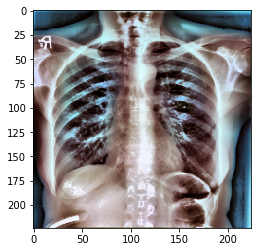

In [8]:
plt.imshow(normal_images[1])

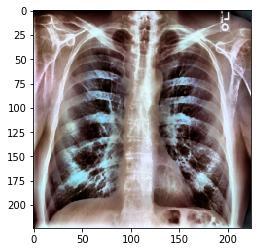

In [9]:
plt.imshow(tb_images[0])

## Feature

In [10]:
from sklearn.preprocessing import StandardScaler
def scaling(X_train,X_test,X_val) :
    #Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    X_val = sc.fit_transform(X_val)
    return X_train,X_test,X_val

In [11]:
from sklearn.metrics import accuracy_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

## Model

In [12]:
from sklearn.ensemble import RandomForestClassifier
def random_model(X_train_recv,y_train_recv,X_test_recv,y_test_recv,X_val_recv,y_val_recv,r) :
    random = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
#     svm = SVC(kernel='rbf', probability=True, C=50, gamma=100)
    #train Model 
    random.fit(X_train_recv,y_train_recv)
    score = random.score(X_test_recv, y_test_recv)
    print("Score : {}".format(score))
    
    y_score = random.predict_proba(X_val_recv)[:, 1]
#     y_check = model_svm.predict(X_val)
#     print(y_check)
    y_pred = random.predict(X_val_recv)
#     print(y_pred)
    accuracy = accuracy_score(y_val_recv,y_pred)
#     for x in zip(y_score2,y_pred) :
#         print(x)
    
    print("Random Forest accuracy from Fold {} : {}".format(r,accuracy))
    #Confusion Matrix
    %matplotlib inline 
    confusion(y_val_recv,y_pred)
    
    #roc
    fpr, tpr, thresholds = roc_curve(y_val_recv, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    
    return fpr,tpr,roc_auc

## Confusion 

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def confusion(y_test,pred) :
    #Confusion Matrix
    %matplotlib inline 

    confusion_mat1 = confusion_matrix(y_test, pred)
    confusion_mat1 = confusion_mat1.astype('float') / confusion_mat1.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(confusion_mat1, annot=True, fmt=".2f")

    plt.show()

## ROC

In [14]:
def roc(fpr_recv,tpr_recv,acc_recv) :
#     stck_auc = []
    color = ["orange","green","blue","red","purple"]
    for i in range(5):
        fpr_use = fpr_recv[i]
        tpr_use = tpr_recv[i]
        acc_use = acc_recv[i]
#         auc = roc_auc_score(y_val_rec, roc_pred)
#         print('AUC Fold %d: %0.4f' %(i,auc))
        
        plt.plot(fpr_use, tpr_use, color='{}'.format(color[i]), label='AUC Fold %d: %0.4f' %(i,acc_use))
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
    plt.show()

## RUN

In [15]:
from sklearn.svm import SVC
import nltk
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
import random
def AllinOne2(other, normal) :
    data = []
    label = []
    box_tpr = []
    box_fpr = []
    box_acc = []
    index = 0
    for i in range(5):
        for count in range(int(normal.shape[0]/5)):
            data.append(normal[index+count].flatten())
            label.append(1)
#             print(index+count)
        for count in range(int(other.shape[0]/5)):
            data.append(other[index+count].flatten())
            label.append(0)
        index+=int(normal.shape[0]/5)  
    data = np.array(data)
    label = np.array(label)
    train_data, X_test, label_train, y_test = train_test_split(data, label, test_size=0.2)
    k=0       
    kf = KFold(5, shuffle=True)
    for train, val in kf.split(train_data):
#         random.shuffle(train)
#         random.shuffle(test)
        X_train = train_data[train]
        X_val = train_data[val]
        y_train = label_train[train]
        y_val = label_train[val]
        print(y_val)
        # Feature      
        X_train_n,X_test_n,X_val_n = scaling(X_train,X_test,X_val)
     # run model
        recv_fpr,recv_tpr,recv_acc = random_model(X_train_n,y_train,X_test_n,y_test,X_val_n,y_val,k)
        box_fpr.append(recv_fpr)
        box_tpr.append(recv_tpr)
        box_acc.append(recv_acc)
        k+=1
        #f1-score
#         cm_plot_labels = ['Finding', 'Normal']
#         print(classification_report(y_val, probs, target_names=cm_plot_labels))
    # ROC
    roc(box_fpr,box_tpr,box_acc)

[1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1
 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0
 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1
 1 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1
 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0
 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0
 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1
 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 1 0]
Score : 0.67
Random Forest accuracy from Fold 0 : 0.65625


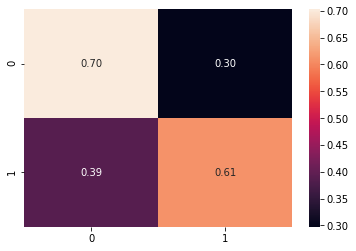

[1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0
 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0
 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0
 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1
 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1
 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1
 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 1 0 0]
Score : 0.675
Random Forest accuracy from Fold 1 : 0.715625


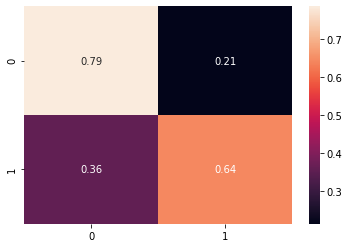

[1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0
 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1
 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1
 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1
 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 0
 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0
 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0
 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1
 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0]
Score : 0.71
Random Forest accuracy from Fold 2 : 0.715625


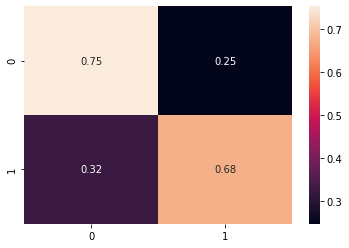

[0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1
 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0
 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1
 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0
 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0
 1 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0
 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1
 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1]
Score : 0.6375
Random Forest accuracy from Fold 3 : 0.65625


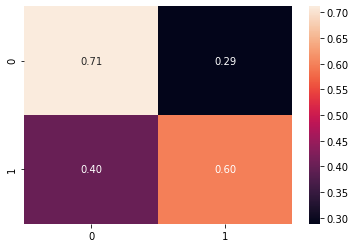

[1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0
 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0
 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0
 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1
 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1
 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0
 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0
 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1
 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 1 1]
Score : 0.6775
Random Forest accuracy from Fold 4 : 0.63125


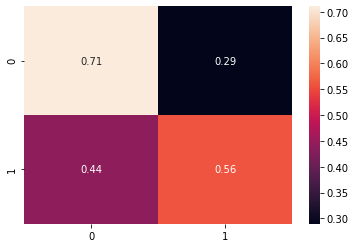

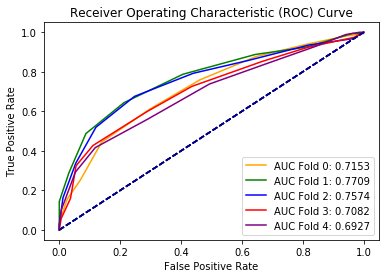

In [16]:
AllinOne2(tb_images, normal_images)